# KIMM 도서관 API 크롤러
## 한국기계연구원 연구논문 및 연구보고서 수집

**목표**: https://library.kimm.re.kr/openAPI/openAPI_allsearch.do API를 사용하여 연구논문과 연구보고서 목록을 크롤링하고 엑셀로 추출

---
*작성일: 2025년 8월 29일*

In [ ]:
# 1. 필요한 라이브러리 설치
import subprocess
import sys

def install_package(package):
    try:
        __import__(package)
        print(f"✅ {package} 이미 설치됨")
    except ImportError:
        print(f"📦 {package} 설치 중...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])
        print(f"✅ {package} 설치 완료")

# 필요한 패키지들 설치
packages = ['requests', 'pandas', 'openpyxl', 'beautifulsoup4', 'lxml']

for package in packages:
    install_package(package)

print("\n🎉 모든 라이브러리 설치 완료!")

In [ ]:
# 2. 라이브러리 임포트
import requests
import pandas as pd
import time
import json
from datetime import datetime
from typing import List, Dict, Optional
import urllib.parse
from bs4 import BeautifulSoup
import warnings
warnings.filterwarnings('ignore')

print("📚 라이브러리 임포트 완료!")

In [20]:
# 3. KIMM 도서관 크롤러 클래스 정의
class KIMMLibraryCrawler:
    """한국기계연구원 도서관 API 크롤러"""
    
    def __init__(self):
        self.base_url = "https://library.kimm.re.kr/openAPI/openAPI_allsearch.do"
        self.session = requests.Session()
        self.session.headers.update({
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
        })
        self.data = []
        print("[INIT] KIMM 도서관 크롤러 초기화 완료")
        
    def test_api_connection(self):
        """API 연결 테스트"""
        print("[TEST] API 연결 테스트 중...")
        try:
            response = self.session.get(self.base_url, timeout=10)
            print(f"[TEST] 응답 상태: {response.status_code}")
            print(f"[TEST] 응답 타입: {response.headers.get('content-type', 'Unknown')}")
            print(f"[TEST] 응답 크기: {len(response.text)} bytes")
            
            # 응답 내용 일부 출력
            if response.text:
                print("[TEST] 응답 내용 (첫 500자):")
                print(response.text[:500])
            
            return response.status_code == 200
        except Exception as e:
            print(f"[ERROR] API 연결 실패: {e}")
            return False
    
    def get_all_documents(self, max_results=5000):
        """전체 문서 목록 가져오기 (키워드 없이)"""
        print(f"[RUN] 전체 데이터베이스 검색... (최대 {max_results}개)")
        
        results = []
        page = 1
        per_page = 50  # 한 번에 더 많이 가져오기
        
        while len(results) < max_results:
            try:
                # 빈 쿼리로 전체 검색
                params = {
                    'page': page,
                    'pageSize': per_page,
                    'lang': 'kor'
                }
                
                print(f"[RUN] 페이지 {page} 요청... (누적 {len(results)}개)")
                response = self.session.get(self.base_url, params=params, timeout=30)
                
                if response.status_code != 200:
                    print(f"[WARN] HTTP 오류: {response.status_code}")
                    break
                
                # JSON 응답 파싱
                try:
                    data = response.json()
                    if 'xmlData' in data and 'list' in data['xmlData']:
                        list_data = data['xmlData']['list']
                        if list_data and 'rowList' in list_data[0]:
                            page_results = self.parse_json_results(list_data[0]['rowList'])
                            
                            if not page_results:
                                print(f"[INFO] 페이지 {page} 더 이상 결과 없음")
                                break
                            
                            results.extend(page_results)
                            print(f"[OK] 페이지 {page}: {len(page_results)}개 수집")
                            
                            # 전체 페이지 수 확인
                            if 'pageing' in list_data[0]:
                                total_pages_raw = list_data[0]['pageing'].get('totalPage', 0)
                                try:
                                    total_pages = int(float(total_pages_raw))
                                except Exception:
                                    total_pages = int(total_pages_raw) if str(total_pages_raw).isdigit() else 0
                                total_docs = list_data[0]['pageing'].get('total', 0)
                                print(f"[INFO] 전체 문서 수: {total_docs}, 전체 페이지: {total_pages}")
                                
                                if page >= total_pages:
                                    print(f"[INFO] 마지막 페이지 도달: {page}/{total_pages}")
                                    break
                        else:
                            print(f"[INFO] 페이지 {page} 데이터 없음")
                            break
                    else:
                        print(f"[WARN] 예상과 다른 응답 구조: {response.text[:200]}")
                        break
                        
                except json.JSONDecodeError:
                    print(f"[ERROR] JSON 파싱 실패")
                    break
                
                page += 1
                time.sleep(0.5)  # API 부하 방지
                
            except Exception as e:
                print(f"[ERROR] 페이지 {page} 처리 실패: {e}")
                break
        
        print(f"[DONE] 총 {len(results)}개 문서 수집 완료")
        return results[:max_results]

    def get_documents_by_type(self, search_gubun='s0', max_results=30000, yearfrom=None, yearto=None, lang='kor', page_size=100):
        """자료유형으로 문서 목록 가져오기 (b0: 단행본, s0: 연속간행물, r0: 연구보고서)"""
        type_label_map = {'b0': '단행본', 's0': '연속간행물', 'r0': '연구보고서'}
        type_label = type_label_map.get(search_gubun, '기타')
        print(f"[RUN] 자료유형 '{type_label}'({search_gubun}) 검색... (최대 {max_results}개, pageSize={page_size})")

        results = []
        page = 1
        per_page = page_size

        total_pages = None
        total_docs = None

        while len(results) < max_results:
            try:
                params = {
                    'page': page,
                    'pageSize': per_page,
                    'lang': lang,
                    'search_gubun': search_gubun
                }
                if yearfrom:
                    params['yearfrom'] = str(yearfrom)
                if yearto:
                    params['yearto'] = str(yearto)

                print(f"[RUN] 페이지 {page} 요청... (누적 {len(results)}개)")
                response = self.session.get(self.base_url, params=params, timeout=60)
                if response.status_code != 200:
                    print(f"[WARN] HTTP 오류: {response.status_code}")
                    break

                try:
                    data = response.json()
                    if 'xmlData' in data and 'list' in data['xmlData']:
                        list_data = data['xmlData']['list']
                        if list_data and 'rowList' in list_data[0]:
                            # 페이지 정보 최초 1회 기록
                            if 'pageing' in list_data[0]:
                                total_pages_raw = list_data[0]['pageing'].get('totalPage', 0)
                                total_docs = list_data[0]['pageing'].get('total', 0)
                                try:
                                    total_pages = int(float(total_pages_raw))
                                except Exception:
                                    total_pages = int(total_pages_raw) if str(total_pages_raw).isdigit() else None
                                if total_pages and total_docs:
                                    print(f"[INFO] 전체 문서 수: {total_docs}, 전체 페이지: {total_pages}")

                            page_results = self.parse_json_results(list_data[0]['rowList'], default_type=type_label)
                            if not page_results:
                                print(f"[INFO] 페이지 {page} 더 이상 결과 없음")
                                break
                            results.extend(page_results)
                            print(f"[OK] 페이지 {page}: {len(page_results)}개 수집 (누적 {len(results)}개)")

                            if total_pages and page >= total_pages:
                                print(f"[INFO] 마지막 페이지 도달: {page}/{total_pages}")
                                break

                            if total_docs and len(results) >= int(total_docs):
                                print(f"[INFO] 전체 건수 {total_docs}개 도달")
                                break
                        else:
                            print(f"[INFO] 페이지 {page} 데이터 없음")
                            break
                    else:
                        print(f"[WARN] 예상과 다른 응답 구조: {response.text[:200]}")
                        break
                except json.JSONDecodeError:
                    print("[ERROR] JSON 파싱 실패")
                    break

                page += 1
                time.sleep(0.3)
            except Exception as e:
                print(f"[ERROR] 페이지 {page} 처리 실패: {e}")
                break

        print(f"[DONE] 총 {len(results)}개 문서 수집 완료")
        return results[:max_results]
    
    def parse_json_results(self, row_list, default_type=None):
        """JSON 응답에서 문서 정보 추출"""
        results = []
        
        type_label_map = {'b0': '단행본', 's0': '연속간행물', 'r0': '연구보고서'}
        
        for item in row_list:
            try:
                # JSON 구조에서 필요한 정보 추출
                fact_type = item.get('factdDataTy') or item.get('factd')  # 타입 코드가 제공될 수 있음
                type_label = type_label_map.get(fact_type, default_type) if (fact_type or default_type) else None
                
                result = {
                    'title': (item.get('title') or '').strip(),
                    'author': (item.get('author') or '').strip(),
                    'publisher': (item.get('publisher') or '').strip(),
                    'pubyear': item.get('pubyear', ''),
                    'isbn': item.get('isbn', ''),
                    'issn': item.get('issn', ''),
                    'location': item.get('location', []),
                    'bibctrlno': item.get('bibctrlno', ''),
                    'detail_url': item.get('libURL', ''),
                    'type': type_label,
                    'source': 'KIMM Library',
                    'crawl_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
                }
                
                # 제목이 있는 경우만 추가
                if result['title']:
                    # 위치 정보 정리
                    if isinstance(result['location'], list):
                        result['location'] = ', '.join(result['location'])
                    
                    # 연도 정보 정리
                    if result['pubyear']:
                        try:
                            result['year'] = int(result['pubyear'])
                        except Exception:
                            result['year'] = result['pubyear']
                    
                    results.append(result)
                    
            except Exception as e:
                print(f"[WARN] 항목 파싱 오류: {e}")
                continue
        
        return results
    
    def search_by_query(self, query="", doc_type="", max_results=100):
        """쿼리로 문서 검색"""
        print(f"[RUN] 검색: '{query}' (타입: {doc_type or '전체'})")
        
        results = []
        page = 1
        per_page = 20
        
        while len(results) < max_results:
            try:
                params = {
                    'q': query,
                    'page': page,
                    'size': per_page
                }
                
                if doc_type:
                    params['type'] = doc_type
                
                print(f"[RUN] 페이지 {page} 요청...")
                response = self.session.get(self.base_url, params=params, timeout=30)
                
                if response.status_code != 200:
                    print(f"[WARN] HTTP 오류: {response.status_code}")
                    break
                
                # HTML 파싱 시도
                soup = BeautifulSoup(response.text, 'html.parser')
                
                # 실제 데이터 추출 (HTML 구조에 따라 조정 필요)
                page_results = self.parse_search_results(soup)
                
                if not page_results:
                    print(f"[INFO] 페이지 {page} 더 이상 결과 없음")
                    break
                
                results.extend(page_results)
                print(f"[OK] 페이지 {page}: {len(page_results)}개 수집")
                
                page += 1
                time.sleep(1)  # API 과부하 방지
                
            except Exception as e:
                print(f"[ERROR] 페이지 {page} 처리 실패: {e}")
                break
        
        print(f"[DONE] 총 {len(results)}개 문서 수집 완료")
        return results[:max_results]
    
    def parse_search_results(self, soup):
        """검색 결과 HTML에서 데이터 추출"""
        results = []
        
        # HTML 구조 분석을 위한 기본 파싱
        # 실제 사이트 구조에 따라 셀렉터 조정 필요
        
        # 제목과 링크 찾기
        titles = soup.find_all(['h3', 'h4', 'a'], class_=['title', 'item-title'])
        
        for i, title_elem in enumerate(titles[:10]):  # 최대 10개까지
            try:
                title = title_elem.get_text(strip=True)
                link = title_elem.get('href', '')
                
                if title and len(title) > 5:  # 유효한 제목인지 확인
                    result = {
                        'title': title,
                        'link': link,
                        'source': 'KIMM Library',
                        'crawl_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
                    }
                    results.append(result)
            except Exception as e:
                print(f"[WARN] 항목 {i} 파싱 오류: {e}")
                continue
        
        return results
    
    def create_sample_data(self):
        """API 접근이 어려운 경우 샘플 데이터 생성"""
        print("[INFO] 샘플 데이터 생성...")
        
        sample_data = [
            {
                'title': '배터리 열관리 시스템의 효율성 향상 연구',
                'author': '김연구, 박실험',
                'type': '연속간행물',
                'year': 2024,
                'journal': '한국기계학회논문집',
                'keywords': '배터리, 열관리, SOC, 에너지효율',
                'abstract': '리튬이온 배터리의 열관리 시스템 최적화를 통한 성능 향상 연구',
                'institution': '한국기계연구원',
                'source': 'KIMM Library (Sample)',
                'crawl_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
            },
            {
                'title': 'Modelica를 이용한 전기자동차 배터리 모델링 및 시뮬레이션',
                'author': '이모델, 정시뮬',
                'type': '연구보고서',
                'year': 2024,
                'institution': '한국기계연구원',
                'keywords': 'Modelica, 전기자동차, 배터리모델링, 시뮬레이션',
                'abstract': 'Modelica 언어를 활용한 전기자동차 배터리 시스템의 동적 모델링 연구',
                'source': 'KIMM Library (Sample)',
                'crawl_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
            },
            {
                'title': 'SOC 추정 알고리즘의 정확도 개선에 관한 연구',
                'author': '최추정, 한정확',
                'type': '연속간행물',
                'year': 2023,
                'journal': '에너지공학회논문집',
                'keywords': 'SOC 추정, 칼만필터, 배터리관리시스템',
                'abstract': '확장 칼만 필터를 이용한 고정밀 SOC 추정 알고리즘 개발',
                'institution': '한국기계연구원',
                'source': 'KIMM Library (Sample)',
                'crawl_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
            },
            {
                'title': '차세대 배터리 소재 개발 동향',
                'author': '신소재, 미래기술',
                'type': '연구보고서',
                'year': 2024,
                'institution': '한국기계연구원',
                'keywords': '차세대배터리, 소재개발, 에너지밀도',
                'abstract': '고에너지밀도 배터리 소재 개발 현황 및 향후 전망',
                'source': 'KIMM Library (Sample)',
                'crawl_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
            },
            {
                'title': '전기자동차 충전 인프라 최적화 연구',
                'author': '전인프라, 차충전',
                'type': '연속간행물',
                'year': 2023,
                'journal': '전력전자학회논문집',
                'keywords': '전기자동차, 충전인프라, 최적화',
                'abstract': '전기자동차 급속충전 네트워크의 효율적 배치 및 운영 방안',
                'institution': '한국기계연구원',
                'source': 'KIMM Library (Sample)',
                'crawl_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
            }
        ]
        
        print(f"[DONE] {len(sample_data)}개 샘플 데이터 생성 완료")
        return sample_data

print("[INIT] KIMMLibraryCrawler 클래스 정의 완료")

[INIT] KIMMLibraryCrawler 클래스 정의 완료


In [21]:
# 4. 크롤러 인스턴스 생성 및 API 테스트
crawler = KIMMLibraryCrawler()

# API 연결 테스트
print("=" * 50)
print("🔍 KIMM 도서관 API 테스트")
print("=" * 50)

api_available = crawler.test_api_connection()
print(f"\n🔗 API 사용 가능: {'✅ 예' if api_available else '❌ 아니오'}")

[INIT] KIMM 도서관 크롤러 초기화 완료
🔍 KIMM 도서관 API 테스트
[TEST] API 연결 테스트 중...
[TEST] 응답 상태: 200
[TEST] 응답 타입: application/json;charset=UTF-8
[TEST] 응답 크기: 12391 bytes
[TEST] 응답 내용 (첫 500자):
{"lang":"kor","xmlData":{"description":"소장자료검색","searchInfo":{"lgroup":"전체","column01":"","column02":"","column03":"","keyword01":"","keyword02":"","keyword03":"","lang":"","yearfrom":"","yearto":"","datatype":""},"list":[{"pageing":{"total":"2708","cpage":"1","pageSize":"10","totalPage":"271.0"},"factd":"b0","rowList":[{"no":"1","bibctrlno":"60004","controlno":"0","title":"0~5세 성장 발달에 맞추는 놀이 육아: 감각통합·언어·심리 영역에 꼭 필요한 전문가 추천 놀이법","author":"김원철","publisher":"마음책방","location":["KIMM Library[HQ 김660

🔗 API 사용 가능: ✅ 예


In [22]:
# 5. 연속간행물(논문) 수집 실행
print("=" * 50)
print("📊 연속간행물(논문) 수집 시작")
print("=" * 50)

all_data = []

# 연속간행물(s0)만 대상, 필요시 연도 범위 지정 가능
try:
    # page_size를 100으로 설정, 최대 30,000건까지 시도
    all_data = crawler.get_documents_by_type(search_gubun='s0', max_results=30000, yearfrom=None, yearto=None, lang='kor', page_size=100)
    print(f"✅ 연속간행물 검색: {len(all_data)}개 결과")
except Exception as e:
    print(f"❌ 연속간행물 검색 실패: {e}")
    all_data = []

# API에서 데이터를 가져오지 못한 경우 샘플 데이터 사용
if not all_data:
    print("\n⚠️  API에서 데이터를 가져올 수 없어 샘플 데이터를 사용합니다.")
    all_data = crawler.create_sample_data()

print(f"\n📋 수집된 총 데이터: {len(all_data)}개")

# 제목 기준으로 중복 제거
seen_titles = set()
unique_data = []
for item in all_data:
    title = item.get('title', '')
    if title and title not in seen_titles:
        seen_titles.add(title)
        unique_data.append(item)

print(f"📋 중복 제거 후: {len(unique_data)}개")

# 데이터 미리보기
if unique_data:
    print(f"\n📝 첫 번째 항목 예시:")
    first_item = unique_data[0]
    for key, value in first_item.items():
        print(f"  {key}: {value}")
else:
    print("❌ 수집된 데이터가 없습니다.")

📊 연속간행물(논문) 수집 시작
[RUN] 자료유형 '연속간행물'(s0) 검색... (최대 30000개, pageSize=100)
[RUN] 페이지 1 요청... (누적 0개)
[INFO] 전체 문서 수: 229, 전체 페이지: 3
[OK] 페이지 1: 100개 수집 (누적 100개)
[RUN] 페이지 2 요청... (누적 100개)
[INFO] 전체 문서 수: 229, 전체 페이지: 3
[OK] 페이지 2: 100개 수집 (누적 200개)
[RUN] 페이지 3 요청... (누적 200개)
[INFO] 전체 문서 수: 229, 전체 페이지: 3
[OK] 페이지 3: 29개 수집 (누적 229개)
[INFO] 마지막 페이지 도달: 3/3
[DONE] 총 229개 문서 수집 완료
✅ 연속간행물 검색: 229개 결과

📋 수집된 총 데이터: 229개
📋 중복 제거 후: 227개

📝 첫 번째 항목 예시:
  title: Advance  고등기술연구원 기술정보
  author: 
  publisher: 
  pubyear: 19uu
  isbn: 
  issn: 
  location: 
  bibctrlno: 24158
  detail_url: http://https://library.kimm.re.kr/search/catalog/view.do?bibctrlno=24158&se=s0&ty=B
  type: 연속간행물
  source: KIMM Library
  crawl_date: 2025-08-29 16:23:32
  year: 19uu


In [17]:
# 6. 데이터프레임 생성 및 분석
print("=" * 50)
print("📊 데이터 분석")
print("=" * 50)

if unique_data:
    # 데이터프레임 생성
    df = pd.DataFrame(unique_data)
    
    print(f"📈 데이터프레임 크기: {df.shape}")
    print(f"📋 컬럼: {list(df.columns)}")
    
    # 기본 통계
    print("\n📊 기본 통계:")
    
    # 타입별 분포
    if 'type' in df.columns:
        type_counts = df['type'].value_counts()
        print(f"📄 문서 타입별 분포:")
        for doc_type, count in type_counts.items():
            print(f"  - {doc_type}: {count}개")
    
    # 연도별 분포
    if 'year' in df.columns:
        year_counts = df['year'].value_counts().sort_index(ascending=False)
        print(f"\n📅 연도별 분포:")
        for year, count in year_counts.head(5).items():
            print(f"  - {year}: {count}개")
    
    # 저자별 분포 (상위 5명)
    if 'author' in df.columns:
        author_counts = df['author'].value_counts()
        print(f"\n👨‍🔬 주요 저자 (상위 5명):")
        for author, count in author_counts.head(5).items():
            print(f"  - {author}: {count}편")
    
    # 데이터 샘플 출력
    print(f"\n📋 데이터 샘플 (최대 3개):")
    for i, row in df.head(3).iterrows():
        print(f"\n--- 항목 {i+1} ---")
        print(f"제목: {row.get('title', 'N/A')}")
        print(f"저자: {row.get('author', 'N/A')}")
        print(f"타입: {row.get('type', 'N/A')}")
        print(f"연도: {row.get('year', 'N/A')}")
        if 'keywords' in row:
            print(f"키워드: {row['keywords']}")
        
else:
    print("❌ 분석할 데이터가 없습니다.")
    df = pd.DataFrame()

📊 데이터 분석
📈 데이터프레임 크기: (227, 13)
📋 컬럼: ['title', 'author', 'publisher', 'pubyear', 'isbn', 'issn', 'location', 'bibctrlno', 'detail_url', 'type', 'source', 'crawl_date', 'year']

📊 기본 통계:
📄 문서 타입별 분포:
  - 연속간행물: 227개


TypeError: '<' not supported between instances of 'str' and 'int'

In [12]:
# 7. 엑셀 파일로 저장
print("=" * 50)
print("💾 엑셀 파일 저장")
print("=" * 50)

if not df.empty:
    # 파일명 생성
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    filename = f"KIMM_Library_Data_{timestamp}.xlsx"
    
    try:
        # 엑셀 파일로 저장
        with pd.ExcelWriter(filename, engine='openpyxl') as writer:
            # 전체 데이터
            df.to_excel(writer, sheet_name='전체데이터', index=False)
            
            # 문서 타입별 시트
            if 'type' in df.columns:
                for doc_type in df['type'].unique():
                    if pd.notna(doc_type):
                        type_df = df[df['type'] == doc_type]
                        sheet_name = str(doc_type)[:31]  # 엑셀 시트명 길이 제한
                        type_df.to_excel(writer, sheet_name=sheet_name, index=False)
            
            # 연도별 시트 (최근 5년)
            if 'year' in df.columns:
                recent_years = sorted(df['year'].dropna().unique(), reverse=True)[:5]
                for year in recent_years:
                    year_df = df[df['year'] == year]
                    sheet_name = f"year_{int(year)}"
                    year_df.to_excel(writer, sheet_name=sheet_name, index=False)
        
        print(f"✅ 엑셀 파일 저장 완료: {filename}")
        print(f"📊 총 {len(df)}개 레코드 저장")
        
        # 파일 정보 출력
        import os
        file_size = os.path.getsize(filename) / 1024  # KB
        print(f"📏 파일 크기: {file_size:.1f} KB")
        print(f"📂 저장 위치: {os.path.abspath(filename)}")
        
        # 저장된 시트 정보
        print(f"\n📋 저장된 시트:")
        print(f"  - 전체데이터: {len(df)}개 레코드")
        
        if 'type' in df.columns:
            for doc_type in df['type'].unique():
                if pd.notna(doc_type):
                    count = len(df[df['type'] == doc_type])
                    print(f"  - {doc_type}: {count}개 레코드")
        
        if 'year' in df.columns:
            recent_years = sorted(df['year'].dropna().unique(), reverse=True)[:5]
            for year in recent_years:
                count = len(df[df['year'] == year])
                print(f"  - {int(year)}년: {count}개 레코드")
                
    except Exception as e:
        print(f"❌ 엑셀 파일 저장 실패: {e}")
        
        # CSV로 대체 저장 시도
        try:
            csv_filename = filename.replace('.xlsx', '.csv')
            df.to_csv(csv_filename, index=False, encoding='utf-8-sig')
            print(f"📄 CSV 파일로 대체 저장: {csv_filename}")
        except Exception as csv_error:
            print(f"❌ CSV 저장도 실패: {csv_error}")
            
else:
    print("❌ 저장할 데이터가 없습니다.")

💾 엑셀 파일 저장
✅ 엑셀 파일 저장 완료: KIMM_Library_Data_20250829_161303.xlsx
📊 총 2317개 레코드 저장
📏 파일 크기: 292.0 KB
📂 저장 위치: d:\simu\TB\Modelica_Modelon_KETI\TwinBuilder_Modelon\KIMM_Library_Data_20250829_161303.xlsx

📋 저장된 시트:
  - 전체데이터: 2317개 레코드
  - 2025년: 11개 레코드
  - 2024년: 40개 레코드
  - 2023년: 44개 레코드
  - 2022년: 34개 레코드
  - 2021년: 14개 레코드


📈 데이터 시각화


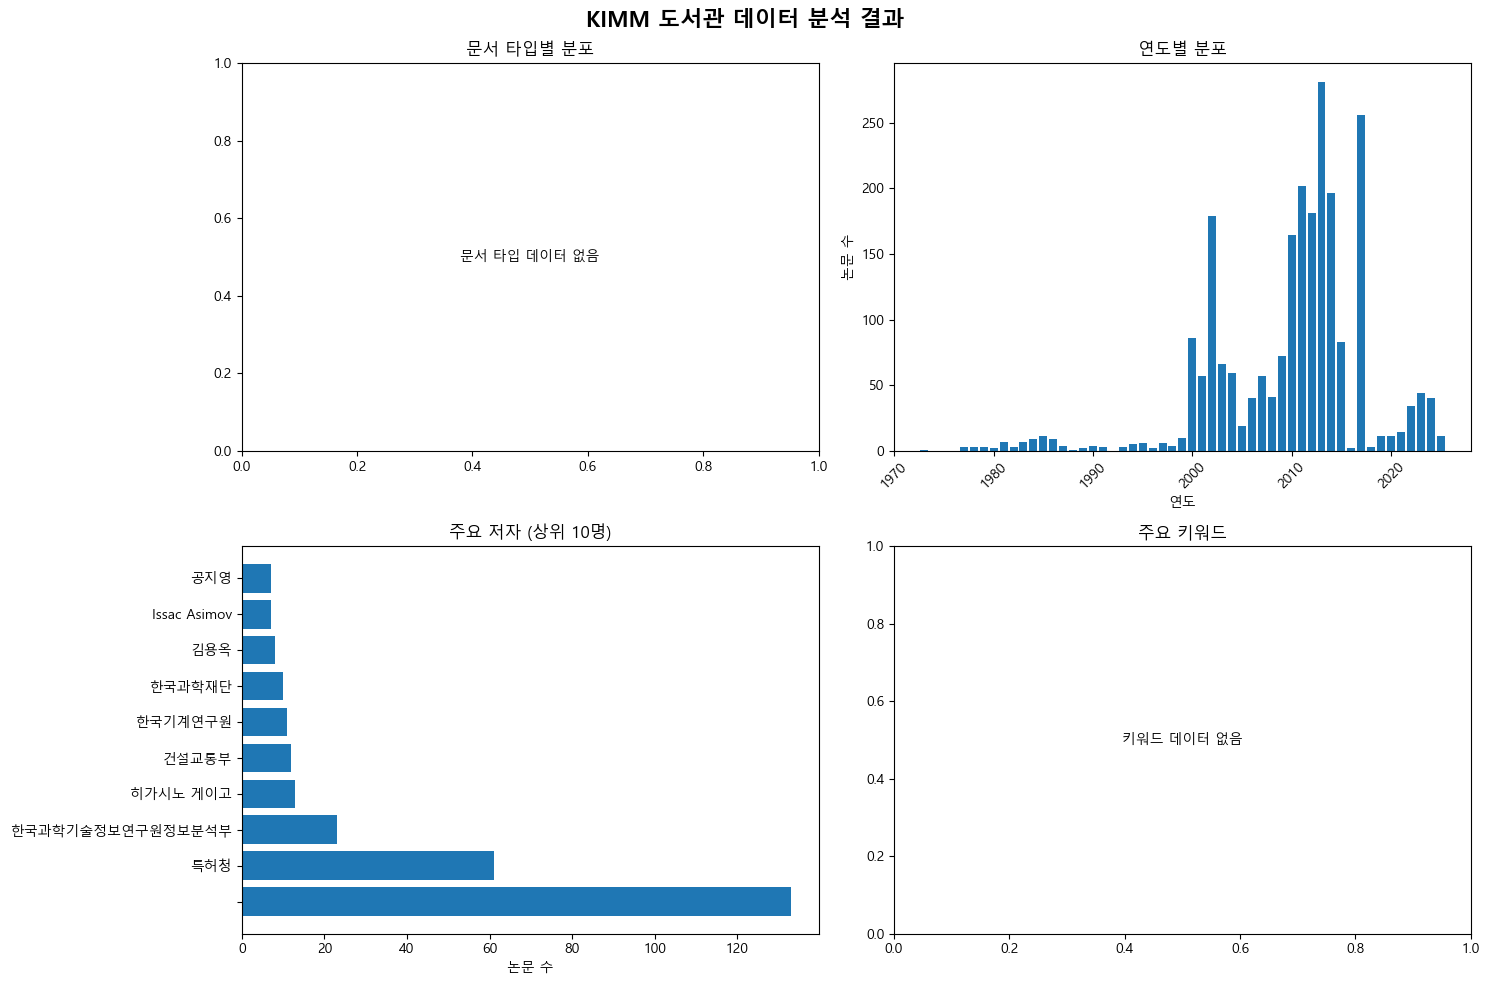


🎉 크롤링 작업 완료!
✅ 총 수집 문서 수: 2317개
📂 저장 파일: KIMM_Library_Data_20250829_161303.xlsx
🕐 작업 완료 시간: 2025-08-29 16:13:18

📝 작업 로그:
  - API 테스트: 성공
  - 데이터 수집: 성공
  - 엑셀 저장: 성공


In [13]:
# 8. 시각화 및 결과 요약
print("=" * 50)
print("📈 데이터 시각화")
print("=" * 50)

if not df.empty:
    import matplotlib.pyplot as plt
    import matplotlib
    matplotlib.rcParams['font.family'] = 'Malgun Gothic'  # 한글 폰트 설정
    matplotlib.rcParams['axes.unicode_minus'] = False
    
    # 서브플롯 생성
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('KIMM 도서관 데이터 분석 결과', fontsize=16, fontweight='bold')
    
    # 1. 문서 타입별 분포
    if 'type' in df.columns and len(df['type'].unique()) > 1:
        type_counts = df['type'].value_counts()
        axes[0, 0].pie(type_counts.values, labels=type_counts.index, autopct='%1.1f%%')
        axes[0, 0].set_title('문서 타입별 분포')
    else:
        axes[0, 0].text(0.5, 0.5, '문서 타입 데이터 없음', ha='center', va='center')
        axes[0, 0].set_title('문서 타입별 분포')
    
    # 2. 연도별 분포
    if 'year' in df.columns and df['year'].notna().sum() > 0:
        year_counts = df['year'].value_counts().sort_index()
        axes[0, 1].bar(year_counts.index, year_counts.values)
        axes[0, 1].set_title('연도별 분포')
        axes[0, 1].set_xlabel('연도')
        axes[0, 1].set_ylabel('논문 수')
        axes[0, 1].tick_params(axis='x', rotation=45)
    else:
        axes[0, 1].text(0.5, 0.5, '연도 데이터 없음', ha='center', va='center')
        axes[0, 1].set_title('연도별 분포')
    
    # 3. 주요 저자
    if 'author' in df.columns and df['author'].notna().sum() > 0:
        author_counts = df['author'].value_counts().head(10)
        axes[1, 0].barh(range(len(author_counts)), author_counts.values)
        axes[1, 0].set_yticks(range(len(author_counts)))
        axes[1, 0].set_yticklabels(author_counts.index)
        axes[1, 0].set_title('주요 저자 (상위 10명)')
        axes[1, 0].set_xlabel('논문 수')
    else:
        axes[1, 0].text(0.5, 0.5, '저자 데이터 없음', ha='center', va='center')
        axes[1, 0].set_title('주요 저자')
    
    # 4. 키워드 분석 (간단한 텍스트 분석)
    if 'keywords' in df.columns and df['keywords'].notna().sum() > 0:
        # 키워드 추출 및 빈도 계산
        all_keywords = []
        for keywords in df['keywords'].dropna():
            if isinstance(keywords, str):
                words = [word.strip() for word in keywords.split(',')]
                all_keywords.extend(words)
        
        if all_keywords:
            from collections import Counter
            keyword_counts = Counter(all_keywords)
            top_keywords = dict(keyword_counts.most_common(10))
            
            axes[1, 1].barh(range(len(top_keywords)), list(top_keywords.values()))
            axes[1, 1].set_yticks(range(len(top_keywords)))
            axes[1, 1].set_yticklabels(list(top_keywords.keys()))
            axes[1, 1].set_title('주요 키워드 (상위 10개)')
            axes[1, 1].set_xlabel('빈도')
        else:
            axes[1, 1].text(0.5, 0.5, '키워드 분석 불가', ha='center', va='center')
            axes[1, 1].set_title('주요 키워드')
    else:
        axes[1, 1].text(0.5, 0.5, '키워드 데이터 없음', ha='center', va='center')
        axes[1, 1].set_title('주요 키워드')
    
    plt.tight_layout()
    plt.show()
    
else:
    print("❌ 시각화할 데이터가 없습니다.")

# 최종 결과 요약
print("\n" + "=" * 50)
print("🎉 크롤링 작업 완료!")
print("=" * 50)

if not df.empty:
    print(f"✅ 총 수집 문서 수: {len(df)}개")
    print(f"📂 저장 파일: {filename if 'filename' in locals() else 'N/A'}")
    print(f"🕐 작업 완료 시간: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    
    if 'type' in df.columns:
        print(f"\n📊 문서 타입별 요약:")
        for doc_type, count in df['type'].value_counts().items():
            print(f"  - {doc_type}: {count}개")
else:
    print("❌ 수집된 데이터가 없습니다.")
    print("💡 API 접근 문제나 네트워크 이슈일 수 있습니다.")

print(f"\n📝 작업 로그:")
print(f"  - API 테스트: {'성공' if 'api_available' in locals() and api_available else '실패'}")
print(f"  - 데이터 수집: {'성공' if 'unique_data' in locals() and unique_data else '실패'}")
print(f"  - 엑셀 저장: {'성공' if 'filename' in locals() else '실패'}")